In [42]:
!pip install skforecast

In [43]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
from skforecast.datasets import fetch_dataset

In [44]:
# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from skforecast.plot import set_dark_theme

In [45]:
# Modelado y Forecasting
# ==============================================================================
import sklearn
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
import skforecast
from skforecast.recursive import ForecasterRecursive
from skforecast.direct import ForecasterDirect
from skforecast.model_selection import TimeSeriesFold, grid_search_forecaster, backtesting_forecaster
from skforecast.preprocessing import RollingFeatures
from skforecast.utils import save_forecaster, load_forecaster
from skforecast.metrics import calculate_coverage
from skforecast.plot import plot_prediction_intervals
import shap
import math

In [46]:
from google.colab import files

uploaded = files.upload()

Saving 001_ZW Parque Ingenio-1AP.csv to 001_ZW Parque Ingenio-1AP (1).csv


In [47]:
import io

#df = pd.read_csv(io.BytesIO(uploaded['001_ZW Parque Ingenio-1AP.csv']))
df = pd.read_csv(io.BytesIO(uploaded['001_ZW Parque Ingenio-1AP (1).csv']), decimal=",")
print(df)

    FECHA.CONEXION  DIA_SEMANA  LABORAL  FIN_DE_SEMANA  FESTIVO  \
0       2024-01-01           0        0              0        1   
1       2024-01-02           1        1              0        0   
2       2024-01-03           2        1              0        0   
3       2024-01-04           3        1              0        0   
4       2024-01-05           4        1              0        0   
..             ...         ...      ...            ...      ...   
451     2025-03-27           3        1              0        0   
452     2025-03-28           4        1              0        0   
453     2025-03-29           5        0              1        0   
454     2025-03-30           6        0              1        0   
455     2025-03-31           0        1              0        0   

     PORCENTAJE.USO  NUMERO.CONEXIONES  USAGE.KB  
0             424.4                 42   3709424  
1             140.3                 21   1181558  
2             168.1                 34   2

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [48]:
# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('once')

color = '\033[1m\033[38;5;208m'
print(f"{color}Versión skforecast: {skforecast.__version__}")
print(f"{color}Versión scikit-learn: {sklearn.__version__}")
print(f"{color}Versión pandas: {pd.__version__}")
print(f"{color}Versión numpy: {np.__version__}")

Versión skforecast: 0.18.0
Versión scikit-learn: 1.6.1
Versión pandas: 2.2.2
Versión numpy: 2.0.2


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [49]:
# Preparación del dato
# ==============================================================================
df['FECHA.CONEXION'] = pd.to_datetime(df['FECHA.CONEXION'], format='%Y-%m-%d')
df = df.set_index('FECHA.CONEXION')
df = df.asfreq('D') # Month Start (04-01; 05-01; 06-01...)
df

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


,DIA_SEMANA,LABORAL,FIN_DE_SEMANA,FESTIVO,PORCENTAJE.USO,NUMERO.CONEXIONES,USAGE.KB
FECHA.CONEXION,,,,,,,
2024-01-01,0,0,0,1,424.4,42,3709424
2024-01-02,1,1,0,0,140.3,21,1181558
2024-01-03,2,1,0,0,168.1,34,2036539
2024-01-04,3,1,0,0,135.1,31,1427081
2024-01-05,4,1,0,0,193.5,35,2097912
...,...,...,...,...,...,...,...
2025-03-27,3,1,0,0,42.0,35,1535923
2025-03-28,4,1,0,0,104.0,25,2514551
2025-03-29,5,0,1,0,242.0,53,7752711


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [50]:
df = df.sort_index() # En caso de que esten las fechas desorganizadas se organizan de forma ascendente
df

,DIA_SEMANA,LABORAL,FIN_DE_SEMANA,FESTIVO,PORCENTAJE.USO,NUMERO.CONEXIONES,USAGE.KB
FECHA.CONEXION,,,,,,,
2024-01-01,0,0,0,1,424.4,42,3709424
2024-01-02,1,1,0,0,140.3,21,1181558
2024-01-03,2,1,0,0,168.1,34,2036539
2024-01-04,3,1,0,0,135.1,31,1427081
2024-01-05,4,1,0,0,193.5,35,2097912
...,...,...,...,...,...,...,...
2025-03-27,3,1,0,0,42.0,35,1535923
2025-03-28,4,1,0,0,104.0,25,2514551
2025-03-29,5,0,1,0,242.0,53,7752711


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [51]:
df

,DIA_SEMANA,LABORAL,FIN_DE_SEMANA,FESTIVO,PORCENTAJE.USO,NUMERO.CONEXIONES,USAGE.KB
FECHA.CONEXION,,,,,,,
2024-01-01,0,0,0,1,424.4,42,3709424
2024-01-02,1,1,0,0,140.3,21,1181558
2024-01-03,2,1,0,0,168.1,34,2036539
2024-01-04,3,1,0,0,135.1,31,1427081
2024-01-05,4,1,0,0,193.5,35,2097912
...,...,...,...,...,...,...,...
2025-03-27,3,1,0,0,42.0,35,1535923
2025-03-28,4,1,0,0,104.0,25,2514551
2025-03-29,5,0,1,0,242.0,53,7752711


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


En caso de que se tenga que convertir la columna PORCENTAJE.USO:

In [52]:
df.dtypes

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


,0
DIA_SEMANA,int64
LABORAL,int64
FIN_DE_SEMANA,int64
FESTIVO,int64
PORCENTAJE.USO,float64
NUMERO.CONEXIONES,int64
USAGE.KB,int64


In [13]:
#df['NUMERO.CONEXIONES'].str.replace(',', '.', regex=True)

In [53]:
print(f'Número de filas con missing values: {df.isnull().any(axis=1).mean()}')

Número de filas con missing values: 0.0


In [54]:
rows_with_na = df[df.isna().any(axis=1)]
print("\nRows with any NA values:")
print(rows_with_na)


Rows with any NA values:
Empty DataFrame
Columns: [DIA_SEMANA, LABORAL, FIN_DE_SEMANA, FESTIVO, PORCENTAJE.USO, NUMERO.CONEXIONES, USAGE.KB]
Index: []


In [55]:
rows, columns = df.shape
rows

456

Steps, el número en que se va a separar el datset en train y test

In [56]:
steps = rows*0.1
steps = math.floor(steps)
steps

45

In [57]:
# Separación datos train-test
# ==============================================================================
df_train = df[:-steps]
df_test  = df[-steps:]
print(f"Fechas train : {df_train.index.min()} --- {df_train.index.max()}  (n={len(df_train)})")
print(f"Fechas test  : {df_test.index.min()} --- {df_test.index.max()}  (n={len(df_test)})")

Fechas train : 2024-01-01 00:00:00 --- 2025-02-14 00:00:00  (n=411)
Fechas test  : 2025-02-15 00:00:00 --- 2025-03-31 00:00:00  (n=45)


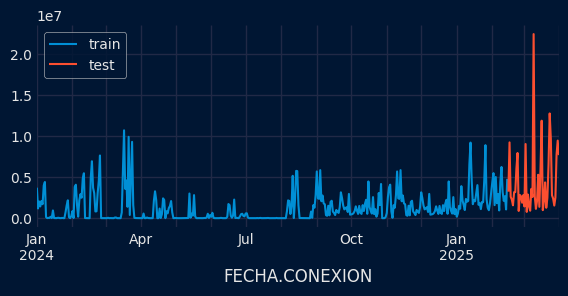

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [58]:
set_dark_theme()
fig, ax = plt.subplots(figsize=(6, 2.5))
df_train['USAGE.KB'].plot(ax=ax, label='train')
df_test['USAGE.KB'].plot(ax=ax, label='test')
ax.legend();

In [59]:
exog_variables = ['DIA_SEMANA', 'LABORAL', 'FIN_DE_SEMANA', 'FESTIVO', 'PORCENTAJE.USO', 'NUMERO.CONEXIONES']
#exog_variables = ['PORCENTAJE.USO', 'NUMERO.CONEXIONES']

In [60]:
# Create and train forecaster WITH exogenous variables
# Keep using ForecasterRecursive as in your original code
forecaster = ForecasterRecursive(
    regressor=RandomForestRegressor(random_state=123),
    lags=6
)
# Ajuste con variables exogenas
forecaster.fit(
    y=df_train['USAGE.KB'],
    exog=df_train[exog_variables]  # Add exogenous variables here
)

# Ajuste sin variables exogenas
#forecaster.fit(
#    y=df_train['USAGE.KB']
#)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [61]:
# Predicciones con variables exogenas futuras
predictions = forecaster.predict(
    steps=steps,
    exog=df_test[exog_variables]  # Future values of exogenous variables
)

# Predicciones sin variables exogenas futuras
#predictions = forecaster.predict(
#    steps=steps
#)
#predictions.head()

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


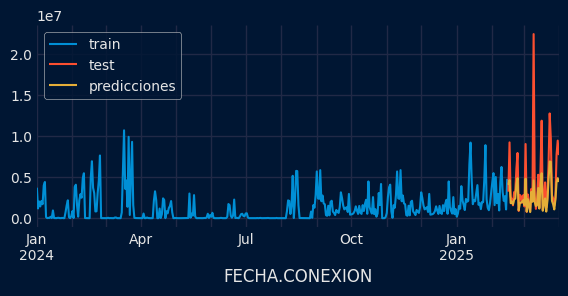

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [62]:
# Gráfico de predicciones vs valores reales
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
df_train['USAGE.KB'].plot(ax=ax, label='train')
df_test['USAGE.KB'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predicciones')
ax.legend();

In [63]:
# Error test
# ==============================================================================
error_mse = mean_squared_error(
                y_true = df_test['USAGE.KB'],
                y_pred = predictions
            )
print(f"Error de test (mse): {error_mse}")

Error de test (mse): 11461517232939.652


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [64]:
# Mean Absolute Percentage Error
mape = mean_absolute_percentage_error(
    y_true=df_test['USAGE.KB'],
    y_pred=predictions
)
print(f"MAPE: {mape:.4f} ({mape*100:.2f}%)")

MAPE: 0.2731 (27.31%)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [65]:
# Root Mean Squared Error
mse = mean_squared_error(df_test['USAGE.KB'], predictions)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse:.2f}")

RMSE: 3385486.26


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [66]:
# Mean Absolute Error
mae = mean_absolute_error(df_test['USAGE.KB'], predictions)
print(f"MAE: {mae:.2f}")

MAE: 1739109.52


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [67]:
# Normalized RMSE (divide by data range)
data_range = df_test['USAGE.KB'].max() - df_test['USAGE.KB'].min()
nrmse = rmse / data_range
print(f"Normalized RMSE: {nrmse:.4f}")

# Coefficient of Variation (RMSE / mean)
cv_rmse = rmse / df_test['USAGE.KB'].mean()
print(f"CV-RMSE: {cv_rmse:.4f}")

Normalized RMSE: 0.1565
CV-RMSE: 0.7627


In [69]:
#print(predictions,df_test['USAGE.KB'])
usage_kb_compared = pd.DataFrame({
    'USAGE.KB_predicho': predictions,
    'USAGE.KB_real': df_test['USAGE.KB']
})
difference = predictions - df_test['USAGE.KB']
usage_kb_compared['error_absoluto'] = difference.abs()
usage_kb_compared['error_relativo'] = usage_kb_compared['error_absoluto'] / usage_kb_compared['USAGE.KB_real']
print(usage_kb_compared)

            USAGE.KB_predicho  USAGE.KB_real  error_absoluto  error_relativo
2025-02-15         4067172.89        3223064       844108.89        0.261896
2025-02-16         4617219.85        9219447      4602227.15        0.499187
2025-02-17         1822370.53        2608034       785663.47        0.301247
2025-02-18         2016797.16        2254409       237611.84        0.105399
2025-02-19         1698539.69        1567471       131068.69        0.083618
2025-02-20         2232956.51        3165363       932406.49        0.294565
2025-02-21         2409133.27        3171790       762656.73        0.240450
2025-02-22         4174818.20        6017300      1842481.80        0.306197
2025-02-23         4871009.74        7930728      3059718.26        0.385805
2025-02-24          965502.07         879736        85766.07        0.097491
2025-02-25         1865593.46        2827149       961555.54        0.340115
2025-02-26         1895917.83        2658594       762676.17        0.286872

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [71]:
# Error test
# ==============================================================================
error_mse = mean_squared_error(
                y_true = df_test['USAGE.KB'],
                y_pred = predictions
            )
print(f"Error de test (mse): {error_mse}")

Error de test (mse): 11461517232939.652


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [88]:
# hyperparameters search: grid search with exogenous variables
forecaster = ForecasterRecursive(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12 # Este valor será remplazado en el grid search
             )

# train and validation partitions
cv = TimeSeriesFold(
      steps              = steps,
      initial_train_size = int(len(df_train) * 0.8),
      refit              = False,
      fixed_train_size   = False,
    )

# candidate values of lags
lags_grid = [10, 14, 18]

# Candidate values of hyperparameters of the regressor
param_grid = {
      'n_estimators': [100, 250],
      'max_depth': [10, 20, 30]
}

resultados_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = df_train['USAGE.KB'],
                        exog        = df_train[exog_variables],  # ADDED: Include exogenous variables
                        cv          = cv,
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        metric      = 'mean_absolute_percentage_error',
                        return_best = True,
                        n_jobs      = 'auto',
                        verbose     = False
                  )

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18] 
  Parameters: {'max_depth': 30, 'n_estimators': 250}
  Backtesting metric: 0.2321986867213934


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [89]:
# Resultados de la búsqueda de hiperparámetros
# ==============================================================================
resultados_grid

,lags,lags_label,params,mean_absolute_percentage_error,max_depth,n_estimators
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 30, 'n_estimators': 250}",0.232199,30,250
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 20, 'n_estimators': 250}",0.232591,20,250
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 250}",0.233467,10,250
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'max_depth': 10, 'n_estimators': 250}",0.233716,10,250
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'max_depth': 10, 'n_estimators': 100}",0.233908,10,100
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'max_depth': 30, 'n_estimators': 250}",0.233977,30,250
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'max_depth': 20, 'n_estimators': 250}",0.234131,20,250
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'max_depth': 20, 'n_estimators': 100}",0.235635,20,100
8,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 100}",0.236380,10,100
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'max_depth': 30, 'n_estimators': 100}",0.236693,30,100


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [90]:
resultados_grid['lags'][0]

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18])

In [91]:
# Crear y entrenar forecaster con mejores hiperparámetros
# ==============================================================================
regressor = RandomForestRegressor(n_estimators=250, max_depth=30, random_state=123)
forecaster = ForecasterRecursive(
                regressor = regressor,
                lags      = 18
             )
# Ajuste con variables exogenas
forecaster.fit(
    y=df_train['USAGE.KB'],
    exog=df_train[exog_variables]  # Add exogenous variables here
)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [93]:
# Predicciones con variables exogenas futuras
predictions = forecaster.predict(
    steps=steps,
    exog=df_test[exog_variables]  # Future values of exogenous variables
)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


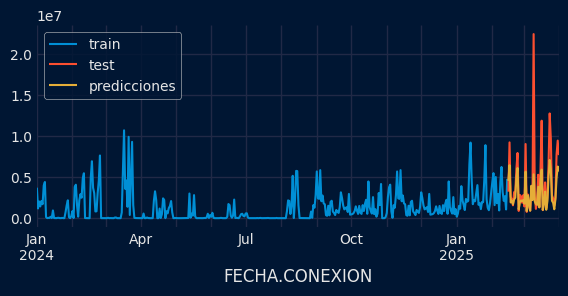

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [94]:
# Gráfico de predicciones vs valores reales
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
df_train['USAGE.KB'].plot(ax=ax, label='train')
df_test['USAGE.KB'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predicciones')
ax.legend();

In [95]:
# Mean Absolute Percentage Error
mape = mean_absolute_percentage_error(
    y_true=df_test['USAGE.KB'],
    y_pred=predictions
)
print(f"MAPE: {mape:.4f} ({mape*100:.2f}%)")

MAPE: 0.2388 (23.88%)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Se prueba con la conversion logaritmica:

In [96]:
df["USAGE_LOG"] = np.log1p(df["USAGE.KB"])
df["PORCENTAJE_LOG"] = np.log1p(df["PORCENTAJE.USO"])
df["CONEXIONES_LOG"] = np.log1p(df["NUMERO.CONEXIONES"])

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [98]:
# Separación datos train-test
# ==============================================================================
df_train = df[:-steps]
df_test  = df[-steps:]
print(f"Fechas train : {df_train.index.min()} --- {df_train.index.max()}  (n={len(df_train)})")
print(f"Fechas test  : {df_test.index.min()} --- {df_test.index.max()}  (n={len(df_test)})")

Fechas train : 2024-01-01 00:00:00 --- 2025-02-14 00:00:00  (n=411)
Fechas test  : 2025-02-15 00:00:00 --- 2025-03-31 00:00:00  (n=45)


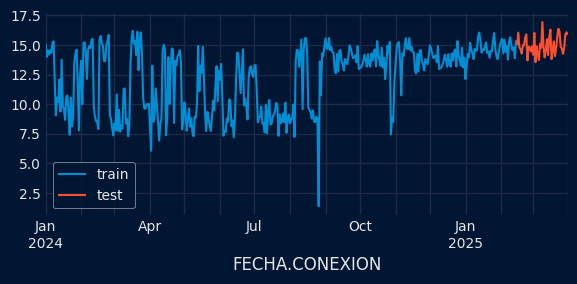

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [99]:
set_dark_theme()
fig, ax = plt.subplots(figsize=(6, 2.5))
df_train['USAGE_LOG'].plot(ax=ax, label='train')
df_test['USAGE_LOG'].plot(ax=ax, label='test')
ax.legend();

In [100]:
exog_variables_log = ['DIA_SEMANA', 'LABORAL', 'FIN_DE_SEMANA', 'FESTIVO', 'PORCENTAJE_LOG', 'CONEXIONES_LOG']

In [101]:
# Create and train forecaster WITH exogenous variables
# Keep using ForecasterRecursive as in your original code
forecaster = ForecasterRecursive(
    regressor=RandomForestRegressor(random_state=123),
    lags=6
)
# Ajuste con variables exogenas
forecaster.fit(
    y=df_train['USAGE_LOG'],
    exog=df_train[exog_variables_log]  # Add exogenous variables here
)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [102]:
# Predicciones con variables exogenas futuras
predictions = forecaster.predict(
    steps=steps,
    exog=df_test[exog_variables_log]  # Future values of exogenous variables
)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


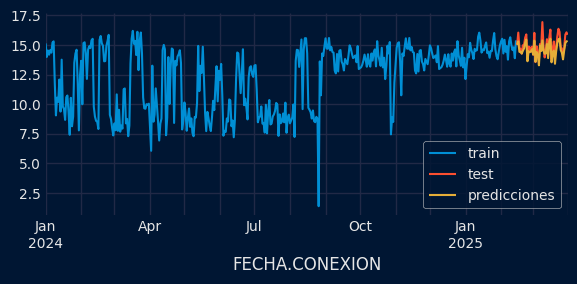

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [103]:
# Gráfico de predicciones vs valores reales
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
df_train['USAGE_LOG'].plot(ax=ax, label='train')
df_test['USAGE_LOG'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predicciones')
ax.legend();

In [104]:
# Mean Absolute Percentage Error
mape = mean_absolute_percentage_error(
    y_true=df_test['USAGE_LOG'],
    y_pred=predictions
)
print(f"MAPE: {mape:.4f} ({mape*100:.2f}%)")

MAPE: 0.0257 (2.57%)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [107]:
#print(predictions,df_test['USAGE.KB'])
usage_kb_compared_log = pd.DataFrame({
    'USAGE.KB_predicho': predictions,
    'USAGE.KB_real': df_test['USAGE_LOG']
})
difference = predictions - df_test['USAGE_LOG']
usage_kb_compared_log['error_absoluto'] = difference.abs()
usage_kb_compared_log['error_relativo'] = usage_kb_compared_log['error_absoluto'] / usage_kb_compared_log['USAGE.KB_real']
print(usage_kb_compared_log)

            USAGE.KB_predicho  USAGE.KB_real  error_absoluto  error_relativo
2025-02-15          15.027832      14.985843        0.041989        0.002802
2025-02-16          15.291941      16.036826        0.744884        0.046448
2025-02-17          14.411018      14.774108        0.363090        0.024576
2025-02-18          14.421097      14.628399        0.207302        0.014171
2025-02-19          14.267434      14.264975        0.002460        0.000172
2025-02-20          14.506541      14.967779        0.461237        0.030815
2025-02-21          14.691840      14.969807        0.277967        0.018569
2025-02-22          15.185478      15.610149        0.424671        0.027205
2025-02-23          15.446911      15.886256        0.439344        0.027656
2025-02-24          13.620019      13.687378        0.067359        0.004921
2025-02-25          14.472307      14.854780        0.382472        0.025747
2025-02-26          14.387449      14.793308        0.405859        0.027435

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


,pred
2025-02-15,3.361277e+06
2025-02-16,4.377294e+06
2025-02-17,1.813950e+06
2025-02-18,1.832325e+06
2025-02-19,1.571331e+06


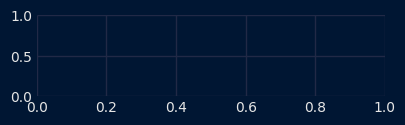

In [108]:
# Se desconvierte el logaritmo
predictions_normal = np.expm1(predictions)
predictions_normal.head()

In [110]:
#print(predictions,df_test['USAGE.KB'])
usage_kb_compared_normal = pd.DataFrame({
    'USAGE.KB_predicho': predictions_normal,
    'USAGE.KB_real': df_test['USAGE.KB']
})
difference = predictions_normal - df_test['USAGE.KB']
usage_kb_compared_normal['error_absoluto'] = difference.abs()
usage_kb_compared_normal['error_relativo'] = usage_kb_compared_normal['error_absoluto'] / usage_kb_compared_normal['USAGE.KB_real']
print(usage_kb_compared_normal)

            USAGE.KB_predicho  USAGE.KB_real  error_absoluto  error_relativo
2025-02-15       3.361277e+06        3223064    1.382134e+05        0.042883
2025-02-16       4.377294e+06        9219447    4.842153e+06        0.525211
2025-02-17       1.813950e+06        2608034    7.940843e+05        0.304476
2025-02-18       1.832325e+06        2254409    4.220837e+05        0.187226
2025-02-19       1.571331e+06        1567471    3.860159e+03        0.002463
2025-02-20       1.995771e+06        3165363    1.169592e+06        0.369497
2025-02-21       2.402065e+06        3171790    7.697250e+05        0.242678
2025-02-22       3.935223e+06        6017300    2.082077e+06        0.346015
2025-02-23       5.111028e+06        7930728    2.819700e+06        0.355541
2025-02-24       8.224294e+05         879736    5.730664e+04        0.065141
2025-02-25       1.928603e+06        2827149    8.985455e+05        0.317827
2025-02-26       1.771697e+06        2658594    8.868970e+05        0.333596

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [111]:
# Mean Absolute Percentage Error
mape = mean_absolute_percentage_error(
    y_true=df_test['USAGE.KB'],
    y_pred=predictions_normal
)
print(f"MAPE: {mape:.4f} ({mape*100:.2f}%)")

MAPE: 0.3024 (30.24%)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


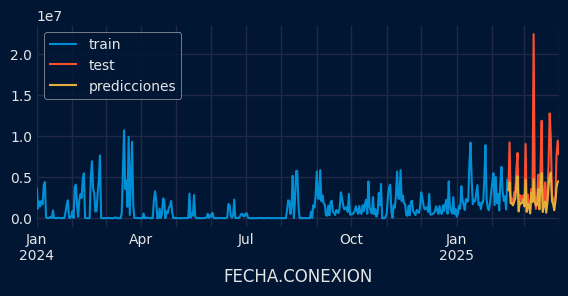

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [112]:
# Gráfico de predicciones vs valores reales
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
df_train['USAGE.KB'].plot(ax=ax, label='train')
df_test['USAGE.KB'].plot(ax=ax, label='test')
predictions_normal.plot(ax=ax, label='predicciones')
ax.legend();